In [1]:
# 导入常用python数据分析库
import pandas as pd
import numpy as np
import seaborn as sns #基于matplolib的画图模块
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sns.set() #seaborn美化样式
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签 
plt.rcParams['axes.unicode_minus']=False
global target

In [2]:
data = pd.read_csv("X_feature71428.csv")
data_val = pd.read_csv('val_feature71428.csv')

In [3]:
data.head()

,Age,SOFA,meanbp_mean,resprate_max,tempc_min,spo2_min,urineoutput,bicarbonate_min,creatinine_max,lactate_max,...,hypertension,diabetes_uncomplicated,diabetes_complicated,renal_failure,metastatic_cancer,fluid_electrolyte,survival_time,status_28d,status_14d,status_7d
0,3.380282,3.684211,4.719944,3.500000,6.016949,9.898990,0.287872,4.054054,0.426829,2.629969,...,0,1,0,0,0,1,1,1,1,1
1,9.718310,3.684211,3.147252,2.000000,6.016949,9.090909,0.524299,4.594595,0.914634,4.220183,...,1,1,0,0,0,1,1,1,1,1
2,5.492958,1.052632,3.018055,3.500000,6.864407,9.393939,0.120841,4.864865,1.707317,3.272171,...,0,0,0,0,1,0,1,1,1,1
3,8.732394,0.000000,3.811383,3.833333,7.203390,9.191919,0.245622,4.054054,0.548780,3.088685,...,1,1,0,0,0,1,1,1,1,1
4,8.028169,4.210526,3.579927,4.333333,7.542373,8.989899,0.154553,3.783784,1.707317,4.220183,...,0,0,0,0,0,0,1,1,1,1


In [29]:
# 要排除出因变量的特征
no_features = ['status_28d','status_14d', 'status_7d', 'survival_time']

# 设置目标变量（因变量）
target = 'status_28d'

columns = list(data.columns)
features = [col for col in columns if col not in no_features]

In [30]:
num_features = data[features].select_dtypes(include=np.number).columns
cat_features = data[features].select_dtypes(exclude=np.number).columns

In [31]:
cat_features

Index([], dtype='object')

In [32]:
num_features

Index(['Age', 'SOFA', 'meanbp_mean', 'resprate_max', 'tempc_min', 'spo2_min',
       'urineoutput', 'bicarbonate_min', 'creatinine_max', 'lactate_max',
       'platelet_min', 'inr_max', 'pt_min', 'wbc_max', 'AKI_Stage', 'sputum',
       'congestive_heart_failure', 'hypertension', 'diabetes_uncomplicated',
       'diabetes_complicated', 'renal_failure', 'metastatic_cancer',
       'fluid_electrolyte'],
      dtype='object')

In [33]:
from sklearn.preprocessing import OneHotEncoder
# 对类别变量进行onehot编码
ohe = OneHotEncoder(handle_unknown='infrequent_if_exist')
ohe_matrix = ohe.fit_transform(data[cat_features])
data_ohe = pd.DataFrame(ohe_matrix.toarray(),
                        columns=ohe.get_feature_names())
ohe_features = list(data_ohe.columns)

x_features = list(num_features) + ohe_features
df = pd.concat([data[num_features],data_ohe],axis=1)

df = pd.concat([df,data[target]],axis=1)

In [34]:
X = df[x_features]
y = df[target]

############## 样本不均衡，进行过采样处理， 如果不需要可注释掉，但效果会变差
from collections import Counter
from imblearn.combine import SMOTETomek
print(Counter(y))
smote_enn = SMOTETomek(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
print(Counter(y_resampled))
X,y = X_resampled,y_resampled
############## 过采样结束 ##############

Counter({0: 968, 1: 914})
Counter({1: 819, 0: 819})


【RF_cls_model】
training time: 0.0220s
finished RandomForestClassifier model training...
evaluation:
{'accuracy': 0.573170731707317, 'precision': 0.5773440847649098, 'recall': 0.5738241308793456, 'f1-score': 0.5685345961589056}


【LR_cls_model】
training time: 0.0150s
finished LogisticRegression model training...
evaluation:
{'accuracy': 0.5762195121951219, 'precision': 0.5771997576859004, 'recall': 0.5758133482059862, 'f1-score': 0.5741254495352857}


【GBDT_cls_model】
training time: 0.2765s
finished GradientBoostingClassifier model training...
evaluation:
{'accuracy': 0.5701219512195121, 'precision': 0.5700892857142856, 'recall': 0.5700501952035695, 'f1-score': 0.5700220344183191}


【MLP_cls_model】
training time: 0.8415s
finished MLPClassifier model training...
evaluation:
{'accuracy': 0.5457317073170732, 'precision': 0.5456845238095238, 'recall': 0.5456590444320506, 'f1-score': 0.5456261214775147}


【SVM_cls_model】
training time: 0.2709s
finished SVC model training...
evaluation:
{'acc

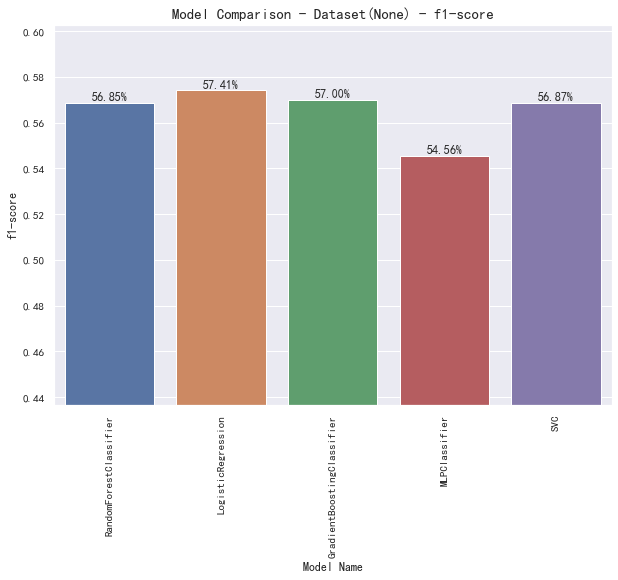

In [35]:
## 训练集80%，测试集20%
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
													test_size=0.20, random_state=30)


import numpy as np
import time
# 定义模型性能评估方法
def evaluation(y_test,y_pred,model_type = 'regression'):
	"""
	传入真实值y_test和预测值y_pred，评估模型效果
	model_type = regression评估回归模型
	model_type = classification评估分类模型
	"""
	metrics = {}
	# if classification model
	if model_type == 'classification':
		from sklearn.metrics import classification_report
		from sklearn.metrics import accuracy_score   #正确率
		from sklearn.metrics import precision_score	#精准率
		from sklearn.metrics import recall_score	  #召回率
		from sklearn.metrics import f1_score		 #调和平均值F1
		# metrics['cls_report'] = classification_report(y_test, y_pred)
		metrics['accuracy'] = accuracy_score(y_test,y_pred)
		metrics['precision'] =  precision_score(y_test,y_pred,average='macro')
		metrics['recall'] = recall_score(y_test,y_pred,average='macro')
		metrics['f1-score'] = f1_score(y_test,y_pred,average='macro')
		
	# if regression model
	elif model_type== 'regression':
		from sklearn.metrics import mean_squared_error
		from sklearn.metrics import mean_absolute_error
		from sklearn.metrics import r2_score
		metrics['MSE'] = mean_squared_error(y_test,y_pred)
		metrics['SCORE'] = mean_squared_error(y_test,y_pred) ** 0.5
		metrics['MAE'] = mean_absolute_error(y_test,y_pred)
		metrics['R2'] = r2_score(y_test,y_pred)
	else:
		raise Exception('model_type should be classification or regression!')
	return metrics


## RF模型
def RF_cls_model(X_train,y_train,X_test,y_test):
	time_start = time.time()
	from sklearn.ensemble import RandomForestClassifier
	RF = RandomForestClassifier(n_estimators=10)
	RF.fit(X_train,y_train)
	time_end = time.time()
	print(f"training time: {(time_end-time_start):.4f}s")
	# 预测模型
	# 测试集预测
	y_pred_RF = RF.predict(X_test)
	# 性能评估
	metrics= evaluation(y_test,y_pred_RF,model_type='classification')
	return RF,metrics

def SVM_cls_model(X_train,y_train,X_test,y_test):
	time_start = time.time()
	### SVM模型
	from sklearn.svm import SVC
	svc = SVC( probability=True)
	# 训练模型
	svc.fit(X_train, y_train)
	time_end = time.time()
	print(f"training time: {(time_end-time_start):.4f}s")
	# 预测测试集结果
	y_pred_SVC = svc.predict(X_test)
	metrics  = evaluation(y_test,y_pred_SVC,model_type='classification')
	return svc,metrics

## 逻辑回归模型
def LR_cls_model(X_train,y_train,X_test,y_test):
	time_start = time.time()
	from sklearn.linear_model import LogisticRegression
	LR = LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=10000)
	# 训练模型
	LR.fit(X_train, y_train)
	time_end = time.time()
	print(f"training time: {(time_end-time_start):.4f}s")
	# 预测测试集结果
	y_pred_LR = LR.predict(X_test)
	metrics  = evaluation(y_test,y_pred_LR,model_type='classification')
	return LR,metrics

# sklearn bp神经网络
def MLP_cls_model(X_train,y_train,X_test,y_test):
	time_start = time.time()
	from sklearn.neural_network import MLPClassifier
	MLP = MLPClassifier(random_state=1, max_iter=300)
	# 训练模型
	MLP.fit(X_train, y_train)
	time_end = time.time()
	print(f"training time: {(time_end-time_start):.4f}s")
	# 预测测试集结果
	y_pred_MLP = MLP.predict(X_test)
	metrics  = evaluation(y_test,y_pred_MLP,model_type='classification')
	return MLP,metrics

def GBDT_cls_model(X_train,y_train,X_test,y_test):
	time_start = time.time()
	### GBDT模型
	from sklearn.ensemble import GradientBoostingClassifier
	gbdt = GradientBoostingClassifier()
	# 训练模型
	gbdt.fit(X_train, y_train)
	time_end = time.time()
	print(f"training time: {(time_end-time_start):.4f}s")
	# 预测测试集结果
	y_pred_GBDT = gbdt.predict(X_test)
	metrics  = evaluation(y_test,y_pred_GBDT,model_type='classification')
	return gbdt,metrics

# 混淆矩阵和roc曲线
def plot_cm_curve(model,X_test,y_test,name=''):
	"""
	画出分类模型的混淆矩阵和roc曲线
	Params
	- model - 传入训练好的模型
	"""
	from sklearn.metrics import ConfusionMatrixDisplay,RocCurveDisplay
	fig = plt.figure(figsize=(10,5))
	ax1 = fig.add_subplot(1,2,1)
	# matplotlib.colormaps()
	ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,ax=ax1,cmap='YlGnBu')
	ax1.set_title("Confusion Matrix")
	ax2 = fig.add_subplot(1,2,2)
	RocCurveDisplay.from_estimator(model,X_test,y_test,ax=ax2)
	ax2.plot([0,1], [0,1], linestyle='--')
	ax2.set_title("ROC Curve")
	plt.grid(False)
	plt.suptitle(type(model).__name__)
	plt.tight_layout()
	plt.savefig(target +'_'+' - '.join([name,type(model).__name__])+'.jpg',dpi=400)
	plt.show()


# 选择要训练的分类模型
cls_models = [RF_cls_model,LR_cls_model,GBDT_cls_model,MLP_cls_model,SVM_cls_model]

# 模型类型为分类模型
model_type = 'classification'
eval_dic = {}
models = []
# 依次训练
for model in cls_models:
	model_name = model.__name__
	print(f"【{model_name}】")
	model,metrics = model(X_train,y_train,X_test,y_test)
	models.append(model)
	# 得到评估结果
	eval_dic[type(model).__name__] = metrics.copy()
	print(f"finished {type(model).__name__} model training...")
	print("evaluation:")
	print(metrics)
	print('\n')

import matplotlib.pyplot as plt
def plot_metric(metric_dic,metric = 'SCORE',dataset_name = 'None'):
	"""
	metric_dic looks like: {'model_name':{'metric_name': value}}
	"""
	# 画图，画出各个模型的指标对比
	x = []
	y = []
	# 提取数据
	for model_name in metric_dic.keys():
		x.append(model_name)
		y.append(metric_dic.get(model_name).get(metric))
	plt.figure(figsize=(10,7))
	# 画柱形图
	sns.barplot(x,y)
	for i,j in zip(range(len(x)),y):
		plt.text(i,j,'{:.2%}'.format(j),va='bottom',ha='center')
	# 设置标题坐标轴名称
	plt.title(f"Model Comparison - Dataset({dataset_name}) - {metric}",fontsize=15)
	plt.xlabel("Model Name")
	plt.ylabel(metric)
	plt.xticks(rotation=90)
	plt.ylim(np.min(y)*0.8,np.max(y)*1.05)
	# 保存图片
	plt.savefig(target +'_'+ f"Model Comparison - Dataset({dataset_name}) - {metric}.jpg",dpi=200)
	plt.show()

# 混淆矩阵和roc曲线
def plot_cm_curve(model,X_test,y_test,name=''):
	"""
	画出分类模型的混淆矩阵和roc曲线
	Params
	- model - 传入训练好的模型
	"""
	from sklearn.metrics import ConfusionMatrixDisplay,RocCurveDisplay
	fig = plt.figure(figsize=(10,5))
	ax1 = fig.add_subplot(1,2,1)
	# matplotlib.colormaps()
	ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,ax=ax1,cmap='YlGnBu')
	ax1.set_title("Confusion Matrix")
	ax2 = fig.add_subplot(1,2,2)
	RocCurveDisplay.from_estimator(model,X_test,y_test,ax=ax2)
	ax2.plot([0,1], [0,1], linestyle='--')
	ax2.set_title("ROC Curve")
	plt.grid(False)
	plt.suptitle(type(model).__name__)
	plt.tight_layout()
	plt.savefig(target +'_'+' - '.join([name,type(model).__name__])+'.jpg',dpi=400)
	plt.show()


####### 分析特征重要性
def plot_feature_importance(model,features,top_n):
	# 提取出特征重要度
	importances = model.feature_importances_
	# 映射成字典
	imp_dict = {feature:importance for feature,importance in zip(features,importances)}
	# 排序
	imp_sorted = sorted(imp_dict.items(),key=lambda x:x[1],reverse=True)
	df_imp = pd.DataFrame(imp_sorted,
				columns=['Features','Importance']).head(top_n)

	# 画图
	plt.figure(figsize=(12,8))
	plt.suptitle('Feature Importance')
	sns.barplot(data = df_imp,x='Features',y='Importance')
	# 输出数值
	for i,j in zip(range(len(df_imp['Features'])),df_imp['Importance']):
			plt.text(i,j,'{:.2}'.format(j),va='bottom',ha='center')
	plt.xticks(rotation=90)
	plt.tight_layout()
	plt.savefig(target +'_'+type(model).__name__+"feature_importance.jpg",dpi=300)
	plt.show()
	

plot_metric(eval_dic,metric='f1-score')

In [36]:
import pickle
for model in models:
	# 保存模型
	s = pickle.dumps(model)
	with open(type(model).__name__+f'_trained_model_{target}.pkl','wb+') as f:#注意此处mode是'wb+'，表示二进制写入
		f.write(s)

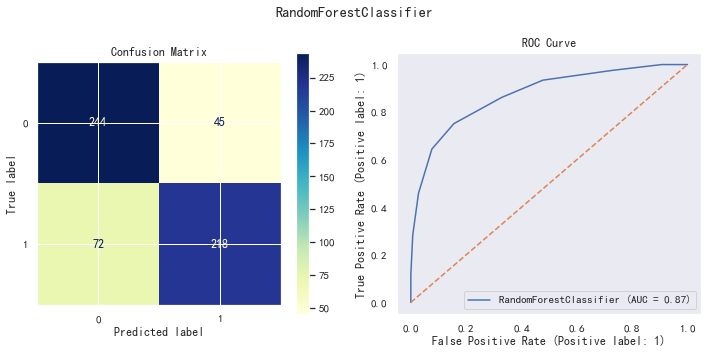

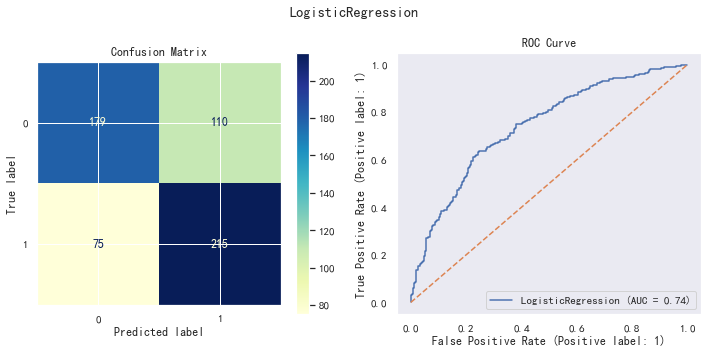

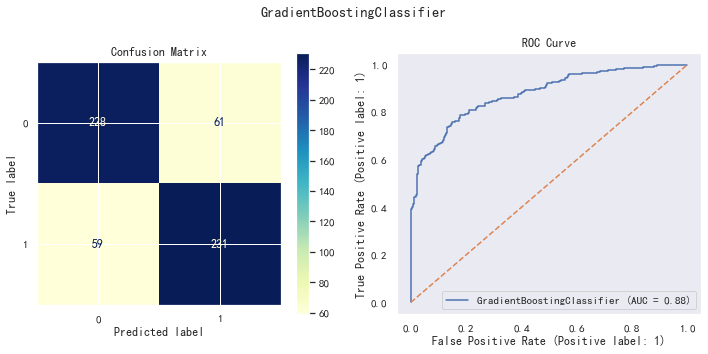

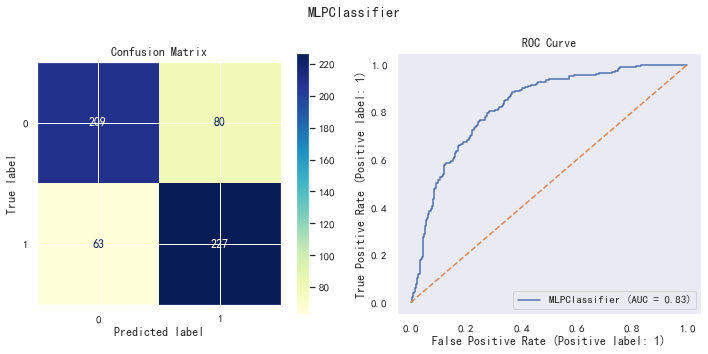

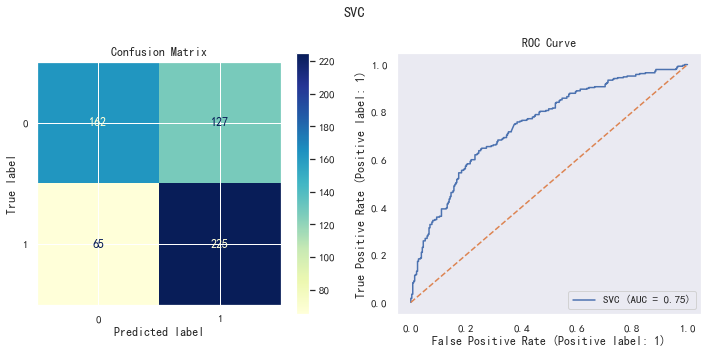

In [12]:
for model in models:
	plot_cm_curve(model,X_test,y_test,name='')

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def calculate_net_benefit_model(thresh_group, y_pred_score, y_label):
    net_benefit_model = np.array([])
    for thresh in thresh_group:
        y_pred_label = y_pred_score > thresh
        tn, fp, fn, tp = confusion_matrix(y_label, y_pred_label).ravel()
        n = len(y_label)
        net_benefit = (tp / n) - (fp / n) * (thresh / (1 - thresh))
        net_benefit_model = np.append(net_benefit_model, net_benefit)
    return net_benefit_model

def calculate_net_benefit_all(thresh_group, y_label):
    net_benefit_all = np.array([])
    tn, fp, fn, tp = confusion_matrix(y_label, y_label).ravel()
    total = tp + tn
    for thresh in thresh_group:
        net_benefit = (tp / total) - (tn / total) * (thresh / (1 - thresh))
        net_benefit_all = np.append(net_benefit_all, net_benefit)
    return net_benefit_all


def plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all,model):
    #Plot
    ax.plot(thresh_group, net_benefit_model, label = type(model).__name__)
    # ax.plot(thresh_group, net_benefit_all, color = 'black',label = 'Treat all')
    # ax.plot((0, 1), (0, 0), color = 'black', linestyle = ':', label = 'Treat none')

    #Fill，显示出模型较于treat all和treat none好的部分
    y2 = np.maximum(net_benefit_all, 0)
    y1 = np.maximum(net_benefit_model, y2)
    # ax.fill_between(thresh_group, y1, y2, color = 'crimson', alpha = 0.2)

    #Figure Configuration， 美化一下细节
    ax.set_xlim(0,1)
    ax.set_ylim(net_benefit_model.min() - 0.15, net_benefit_model.max() + 0.15)#adjustify the y axis limitation
    ax.set_xlabel(
        xlabel = 'Threshold Probability', 
        # fontdict= {'family': 'Times New Roman', 'fontsize': 15}
        )
    ax.set_ylabel(
        ylabel = 'Net Benefit', 
        # fontdict= {'family': 'Times New Roman', 'fontsize': 15}
        )
    ax.grid('major')
    ax.spines['right'].set_color((0.8, 0.8, 0.8))
    ax.spines['top'].set_color((0.8, 0.8, 0.8))
    ax.legend()
    return ax

def decision_curve_analysis(models,X_test,y_true):
    """binary classification"""
    fig, ax = plt.subplots()
    fig.set_size_inches(8,6)
    for model in models:
        thresh_group = np.arange(0,1,0.01)
        y_pred_prob = model.predict_proba(X_test)[:,1]
        net_benefit_model = calculate_net_benefit_model(thresh_group, y_pred_prob, y_true)
        net_benefit_all = calculate_net_benefit_all(thresh_group, y_true)
        ax = plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all,model)
    ax.plot(thresh_group, net_benefit_all, color = 'black',label = 'Treat all')
    ax.plot((0, 1), (0, 0), color = 'black', linestyle = ':', label = 'Treat none')
    plt.legend()
    plt.title(f"Decision Curve Analysis")
    fig.savefig("models_DCA.jpg", dpi = 300)
    plt.show()


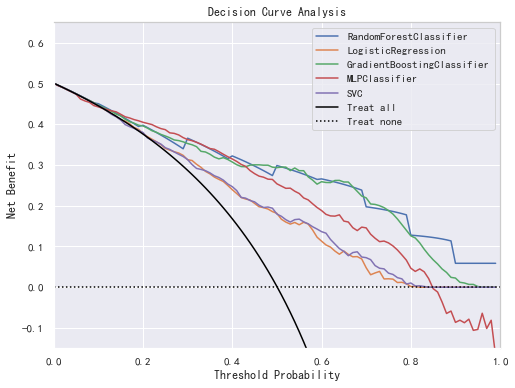

In [14]:
# for model in models:
# 	decision_curve_analysis(model,X_test,y_test)
decision_curve_analysis(models,X_test,y_test)

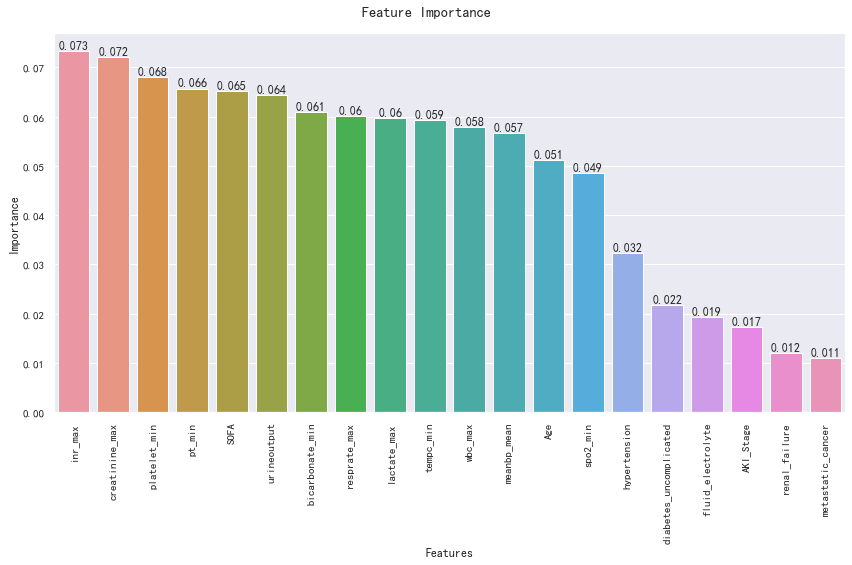

In [15]:
RF_model = models[0]
plot_feature_importance(RF_model,x_features,20)

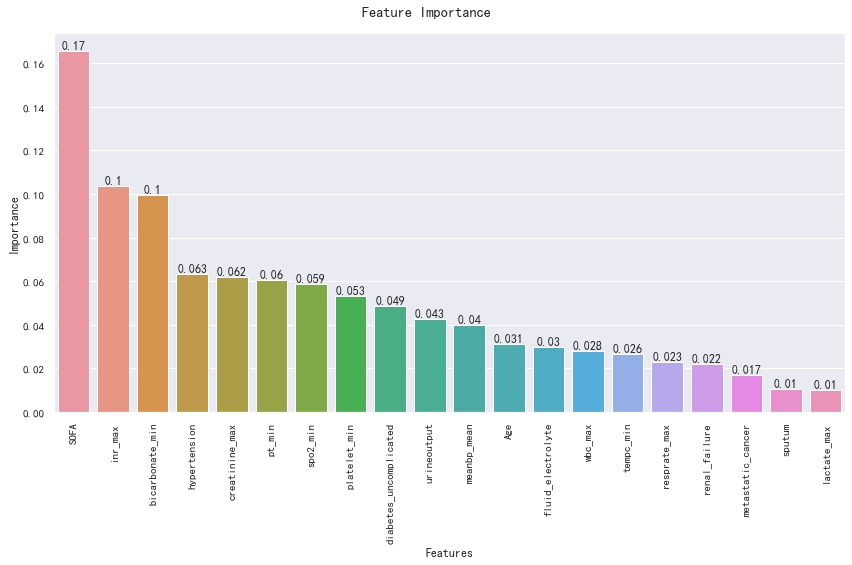

In [16]:
GBDT_model = models[2]
plot_feature_importance(GBDT_model,x_features,20)

In [17]:
from sklearn.impute import SimpleImputer
sip = SimpleImputer(missing_values=np.nan,strategy='most_frequent')
data_val[features] = pd.DataFrame(sip.fit_transform(data_val[features]),columns=features)

In [18]:
from sklearn.preprocessing import OneHotEncoder
# 对类别变量进行onehot编码
ohe_matrix = ohe.transform(data_val[cat_features])
data_val_ohe = pd.DataFrame(ohe_matrix.toarray(),
                        columns=ohe.get_feature_names())
ohe_val_features = list(data_val_ohe.columns)

x_features = list(num_features) + ohe_val_features
df_val = pd.concat([data_val[num_features],data_val_ohe],axis=1)

df_val = pd.concat([df_val,data_val[target]],axis=1)

In [19]:
print(list(data_val.columns))

['Age', 'SOFA', 'meanbp_mean', 'resprate_max', 'tempc_min', 'spo2_min', 'urineoutput', 'bicarbonate_min', 'creatinine_max', 'lactate_max', 'platelet_min', 'inr_max', 'pt_min', 'wbc_max', 'AKI_Stage', 'sputum', 'congestive_heart_failure', 'hypertension', 'diabetes_uncomplicated', 'diabetes_complicated', 'renal_failure', 'metastatic_cancer', 'fluid_electrolyte', 'survival_time', 'status_7d', 'status_14d', 'status_28d']


In [20]:
X_val = df[x_features]
X_val= pd.DataFrame(rfe.transform(X_val),columns=rfe.get_feature_names_out())
y_val = df[target]

NameError: name 'rfe' is not defined

In [127]:
eval_dic = {}
print("外部验证集表现:")
for model in models:
	model_name = type(model).__name__
	print(f"【{model_name}】")
	y_pred = model.predict(X_val)
	res = evaluation(y_val,y_pred,model_type='classification')
	eval_dic[model_name] = res
	print(res)

外部验证集表现:
【RandomForestClassifier】
{'accuracy': 0.8437832093517534, 'precision': 0.8459806956505858, 'recall': 0.8425863970920665, 'f1-score': 0.8431020930382913}
【LogisticRegression】
{'accuracy': 0.5982996811902231, 'precision': 0.5992638734161164, 'recall': 0.5990978262835235, 'f1-score': 0.5982543108560043}
【GradientBoostingClassifier】
{'accuracy': 0.7545164718384697, 'precision': 0.7547632924889757, 'recall': 0.7549245438269707, 'f1-score': 0.7545028867264794}
【MLPClassifier】
{'accuracy': 0.7221041445270988, 'precision': 0.7218754417210866, 'recall': 0.7217683599471942, 'f1-score': 0.7218118915166822}
【SVC】
{'accuracy': 0.5929861849096706, 'precision': 0.5960947024906269, 'recall': 0.5947870137620486, 'f1-score': 0.5921345084831695}


In [131]:
data_val

,Age,SOFA,meanbp_mean,resprate_max,tempc_min,spo2_min,urineoutput,bicarbonate_min,creatinine_max,lactate_max,...,hypertension,diabetes_uncomplicated,diabetes_complicated,renal_failure,metastatic_cancer,fluid_electrolyte,survival_time,status_7d,status_14d,status_28d
0,9.545455,2.0,2.935680,3.421053,1.612903,9.7,1.583408,4.885714,2.261905,0.984456,...,1.0,0.0,1.0,0.0,0.0,0.0,360.0,0,0,0
1,6.818182,3.0,0.000000,1.052632,0.000000,0.0,1.004509,4.485714,2.803030,5.129534,...,1.0,0.0,1.0,0.0,0.0,0.0,3.1,1,1,1
2,8.181818,5.5,1.930656,3.684211,4.516129,9.6,6.311993,2.942857,1.774892,2.435233,...,1.0,0.0,1.0,0.0,0.0,1.0,397.0,0,0,0
3,4.545455,6.0,5.531536,3.684211,3.225806,9.5,0.000000,0.000000,3.614719,6.528497,...,1.0,0.0,0.0,1.0,0.0,1.0,1.2,1,1,1
4,9.318182,8.0,2.906786,3.421053,3.225806,8.9,0.234445,3.142857,6.071429,1.554404,...,1.0,0.0,0.0,0.0,0.0,0.0,103.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,9.090909,6.5,4.815576,1.578947,0.000000,9.4,0.396754,4.628571,3.852814,0.984456,...,1.0,0.0,0.0,1.0,0.0,1.0,149.0,0,0,0
96,3.636364,2.5,3.557540,2.631579,0.000000,9.8,0.991885,0.914286,2.359307,6.632124,...,0.0,0.0,0.0,1.0,0.0,1.0,3.5,1,1,1
97,9.318182,1.5,3.600880,2.368421,3.225806,9.8,3.877367,3.914286,1.590909,1.264249,...,1.0,0.0,1.0,0.0,0.0,1.0,229.0,0,0,0
98,9.772727,6.5,6.203894,0.789474,3.225806,9.8,1.172227,3.685714,1.937229,0.829016,...,1.0,0.0,0.0,0.0,0.0,1.0,14.0,0,1,1
